In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
from torch.utils.data import Dataset, DataLoader
import glob

In [ ]:
class Flickr8kDataset(Dataset):
    def __init__(self, img_dir):
        self.img_paths = glob.glob(f"{img_dir}/*.jpg") 

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        return image

In [ ]:
dataset = Flickr8kDataset(img_dir="flickr8k/images")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
for batch in dataloader:  
    images = batch
    print(f"Batch shape: {images.shape}")  
    break

Batch shape: torch.Size([32, 3, 224, 224])


In [ ]:
image_paths = glob.glob("flickr8k/images/*.jpg")
print(f"Total Images: {len(image_paths)}")

Total Images: 8091


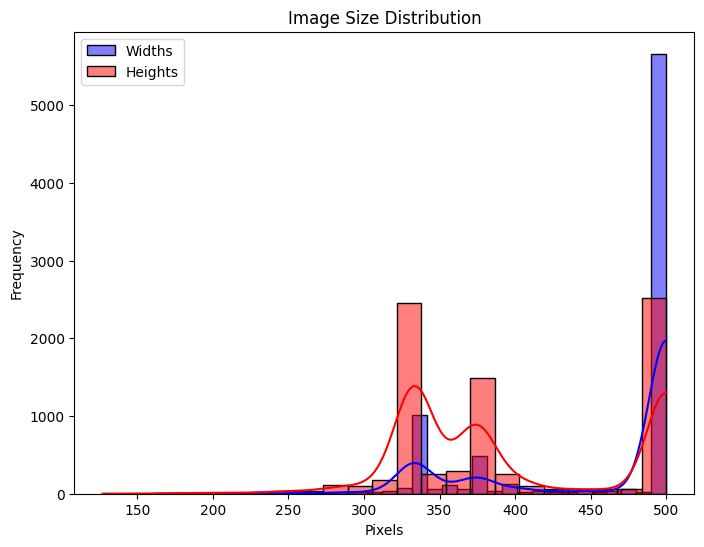

In [ ]:
sizes = [Image.open(img).size for img in image_paths]
widths, heights = zip(*sizes)

plt.figure(figsize=(8, 6))
sns.histplot(widths, kde=True, color="blue", label="Widths")
sns.histplot(heights, kde=True, color="red", label="Heights")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.title("Image Size Distribution")
plt.legend()
plt.show()


In [10]:
from torchvision.transforms import ToTensor

# RGB values shape size vectors
mean = torch.zeros(3, device=device)
std = torch.zeros(3, device=device)
num_samples = 0

# process images in batches
batch_size = 32  
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i : i + batch_size]
    
    batch_tensors = [ToTensor()(Image.open(img)).view(3, -1).to(device) for img in batch_paths]
    batch_tensors = torch.cat(batch_tensors, dim=1)
    
    mean += batch_tensors.mean(dim=1)  # mean per channel
    std += batch_tensors.std(dim=1)    # std per channel
    num_samples += 1

# final mean and std
mean /= num_samples
std /= num_samples

# results back to CPU for printing
print("Info for Normalization:")
print(f"Mean: {mean.cpu().numpy()}")
print(f"Std Dev: {std.cpu().numpy()}")

Info for Normalization:
Mean: [0.458247   0.44612014 0.40394703]
Std Dev: [0.2774884  0.2700025  0.28378925]


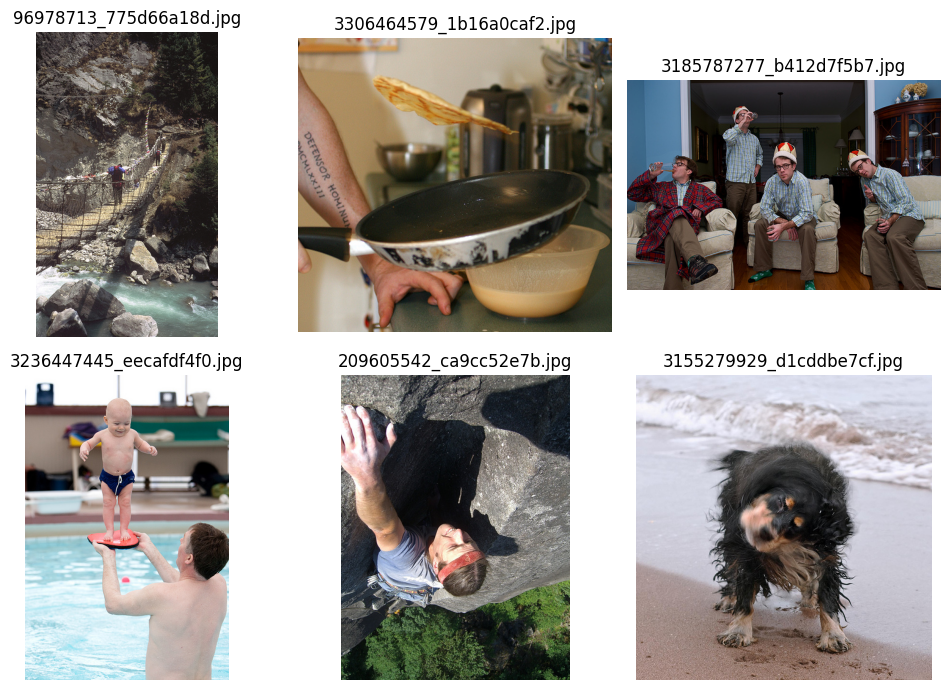

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for ax in axes.flatten():
    img_path = np.random.choice(image_paths)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(os.path.basename(img_path))

plt.tight_layout()
plt.show()

Caption

In [15]:
import pandas as pd

caption_file = "flickr8k/captions.txt"
df = pd.read_csv(caption_file, delimiter=',')
df.columns = ["image", "caption"]

df["image"] = df["image"].str.strip()
df["caption"] = df["caption"].str.strip()

df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [16]:
print(f"Total Captions: {len(df)}")
print(f"Unique Images: {df['image'].nunique()}")
print(f"Avg Captions per Image: {len(df) / df['image'].nunique():.2f}")

Total Captions: 40455
Unique Images: 8091
Avg Captions per Image: 5.00


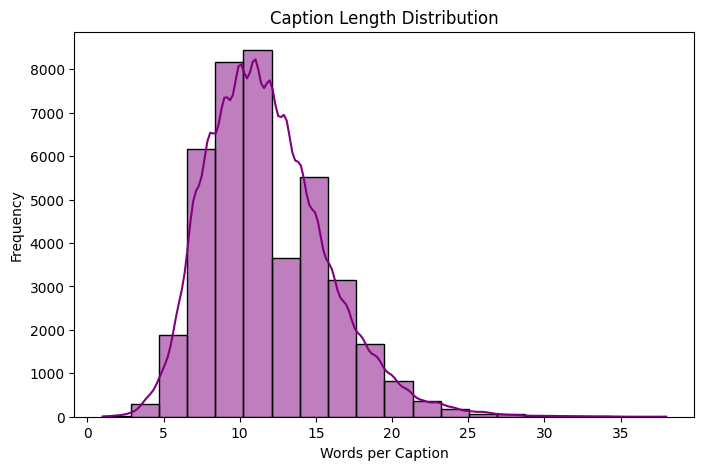

In [17]:
df["caption_length"] = df["caption"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df["caption_length"], bins=20, kde=True, color="purple")
plt.xlabel("Words per Caption")
plt.ylabel("Frequency")
plt.title("Caption Length Distribution")
plt.show()


/tmp/ipykernel_9743/4178642781.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=common_words, palette="magma")


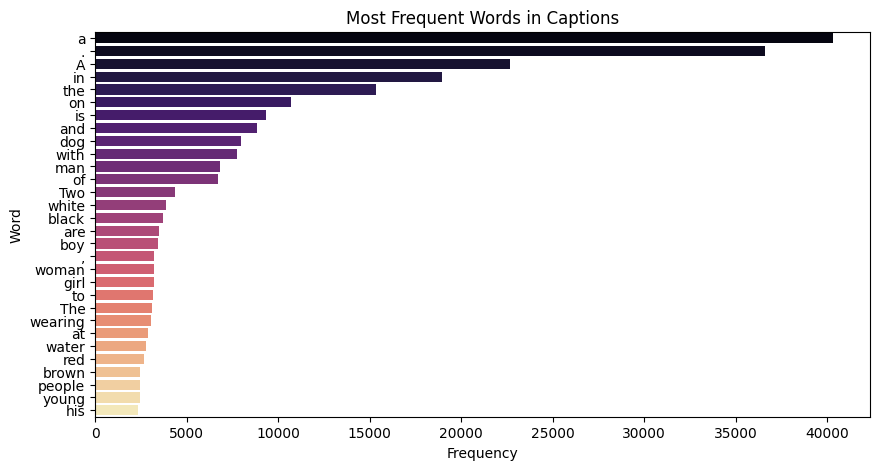

In [18]:
from collections import Counter

all_words = " ".join(df["caption"]).split()
word_freq = Counter(all_words)

common_words = pd.DataFrame(word_freq.most_common(30), columns=["Word", "Frequency"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Frequency", y="Word", data=common_words, palette="magma")
plt.title("Most Frequent Words in Captions")
plt.show()


In [19]:
vocab_size = len(set(all_words))
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 9630
